In [16]:
# Basic imports
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & ML
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate



In [17]:
# Load dataset
df = pd.read_csv("C:\\Users\\gsred\\Downloads\\EV_Dataset (1).csv")
print("Dataset Shape:", df.shape)


Dataset Shape: (96845, 8)


In [18]:
# Convert Date column
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Drop missing values
df = df.dropna()

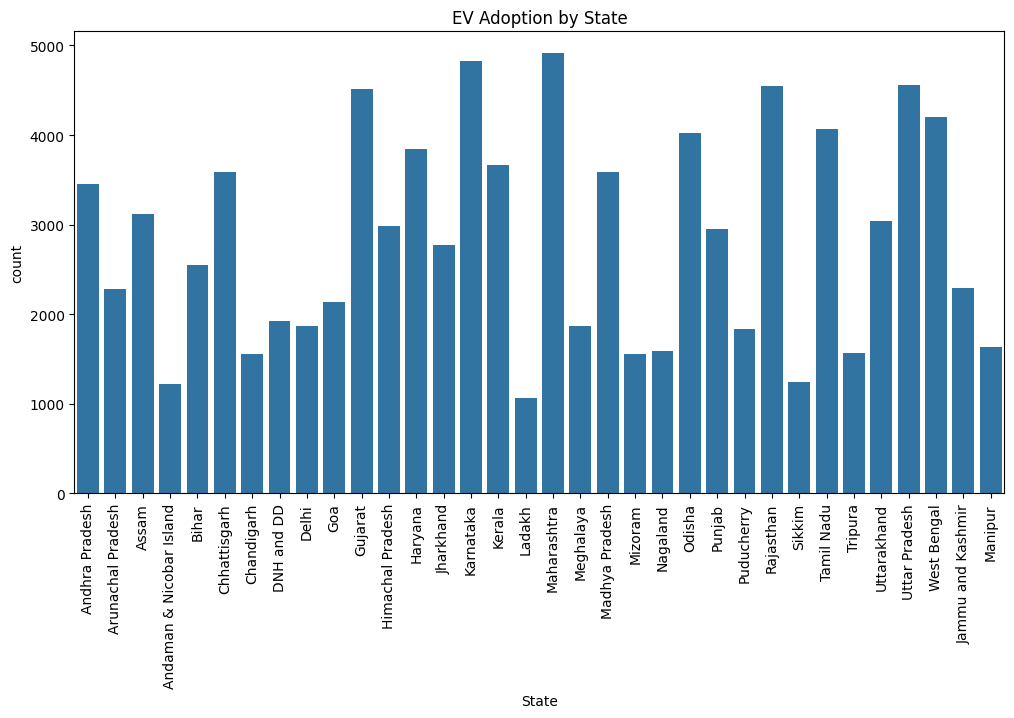

In [19]:
plt.figure(figsize=(12,6))
sns.countplot(x="State", data=df)
plt.title("EV Adoption by State")

# Replace numbers with names on x-axis
plt.xticks(ticks=range(len(df['State'].unique())), labels=df['State'].unique(), rotation=90)

plt.show()


In [20]:
# Group EV count per state
state_ev = df.groupby('State')['Vehicle_Type'].count().reset_index()
state_ev.rename(columns={'Vehicle_Type':'EV_Count'}, inplace=True)

# Scale EV counts
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
state_ev_scaled = scaler.fit_transform(state_ev[['EV_Count']])

# KMeans clustering for Low/Medium/High adoption
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
state_ev['Cluster'] = kmeans.fit_predict(state_ev_scaled)

# Map clusters to Low/Medium/High
cluster_centers = kmeans.cluster_centers_.flatten()
cluster_map = {i: cat for i, cat in zip(cluster_centers.argsort(), ['Low','Medium','High'])}
state_ev['Adoption_Category'] = state_ev['Cluster'].map(cluster_map)

# Merge with main dataset
df = df.merge(state_ev[['State','Adoption_Category']], on='State', how='left')

# Encode Adoption_Category
le_adoption = LabelEncoder()
df['Adoption_Category'] = le_adoption.fit_transform(df['Adoption_Category'])


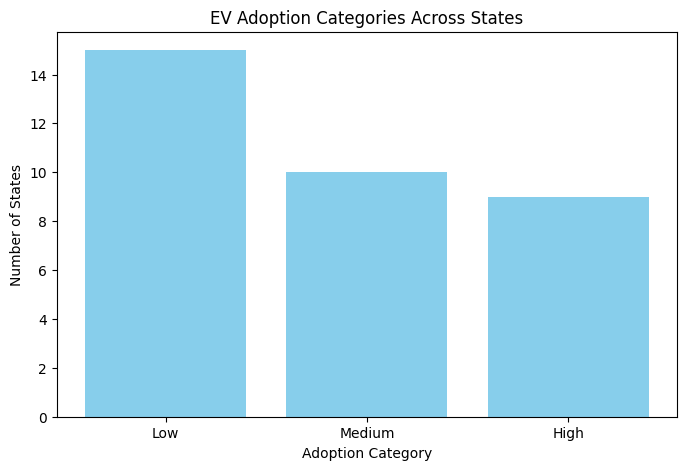

In [21]:
import matplotlib.pyplot as plt

# Count per category
counts = state_ev['Adoption_Category'].value_counts().reindex(['Low','Medium','High'])

# Single color
color = 'skyblue'

# Plot
plt.figure(figsize=(8,5))
plt.bar(counts.index, counts.values, color=color)
plt.title('EV Adoption Categories Across States')
plt.xlabel('Adoption Category')
plt.ylabel('Number of States')
plt.show()


In [22]:
# Encode categorical columns (excluding target)
categorical_cols = ['Month_Name', 'State', 'Vehicle_Class', 'Vehicle_Category']
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Encode target
le_target = LabelEncoder()
df['Vehicle_Type'] = le_target.fit_transform(df['Vehicle_Type'])



In [23]:
# Features & target
X = df.drop(columns=['Vehicle_Type','Date','Adoption_Category'])
y = df['Vehicle_Type']

print("Features shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Features shape: (96845, 6)
Target distribution:
 Vehicle_Type
11    54423
0     11700
9      7026
8      4580
7      4111
5      3786
2      3208
10     2093
6      1951
3      1517
1      1421
4      1029
Name: count, dtype: int64


In [24]:
df.isnull().sum()

Year                 0
Month_Name           0
Date                 0
State                0
Vehicle_Class        0
Vehicle_Category     0
Vehicle_Type         0
EV_Sales_Quantity    0
Adoption_Category    0
dtype: int64

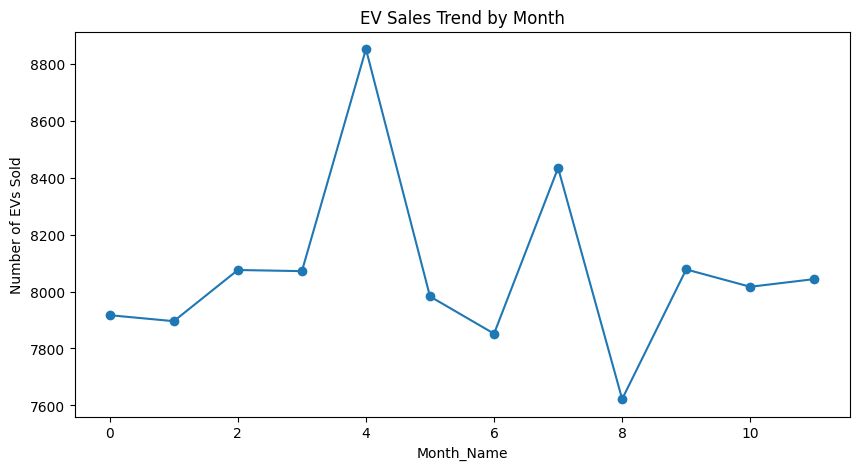

In [25]:
# EV Trends Over Time
#Check monthly or yearly trends
monthly_trend = df.groupby('Month_Name')['Vehicle_Type'].count()
monthly_trend.plot(kind='line', marker='o', figsize=(10,5))
plt.title('EV Sales Trend by Month')
plt.ylabel('Number of EVs Sold')
plt.show()


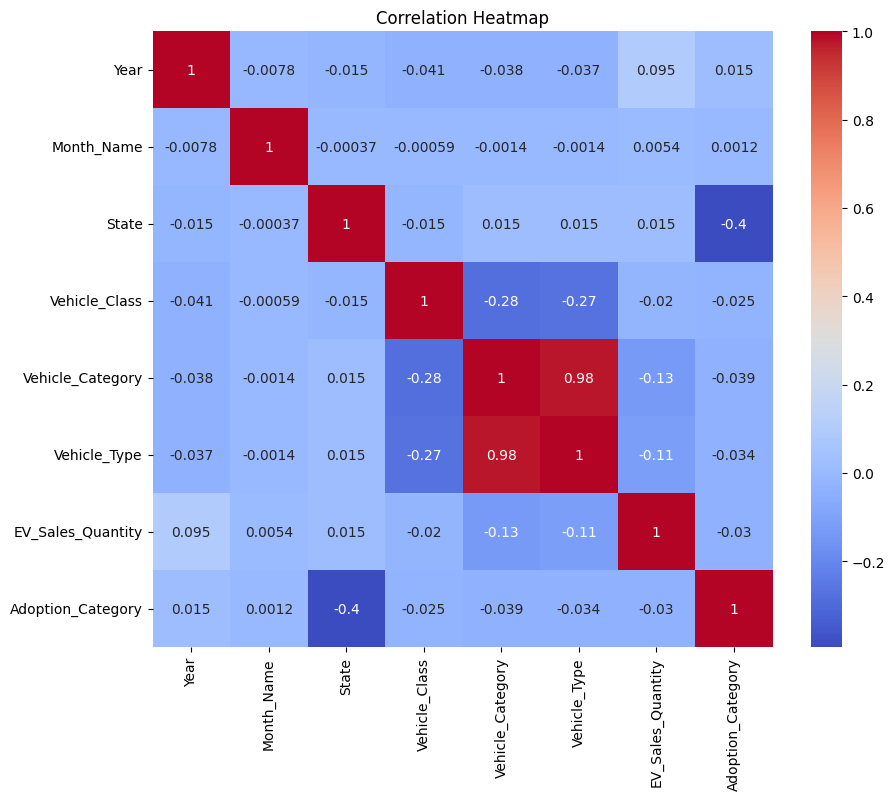

In [26]:
#Correlation Analysis
#Check numeric feature correlations
numeric_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(10,8))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()


In [27]:
X = pd.get_dummies(X, columns=['State'], drop_first=True)


In [28]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Training samples:", X_train.shape[0])
print("Testing samples:", X_test.shape[0])
print("Class distribution in training data:\n", y_train.value_counts())


Training samples: 77476
Testing samples: 19369
Class distribution in training data:
 Vehicle_Type
11    43538
0      9360
9      5621
8      3664
7      3289
5      3029
2      2566
10     1674
6      1561
3      1214
1      1137
4       823
Name: count, dtype: int64


In [29]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:\n", y_train.value_counts())
print("After SMOTE:\n", pd.Series(y_train_res).value_counts())


Before SMOTE:
 Vehicle_Type
11    43538
0      9360
9      5621
8      3664
7      3289
5      3029
2      2566
10     1674
6      1561
3      1214
1      1137
4       823
Name: count, dtype: int64
After SMOTE:
 Vehicle_Type
11    43538
2     43538
0     43538
9     43538
4     43538
7     43538
5     43538
8     43538
10    43538
6     43538
3     43538
1     43538
Name: count, dtype: int64


In [30]:
def evaluate_model_cv(model, X, y, cv=5):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)
    scoring = ['accuracy', 'f1_weighted']
    scores = cross_validate(model, X, y, cv=skf, scoring=scoring, return_train_score=False)
    print(f"Mean Accuracy: {scores['test_accuracy'].mean():.4f}")
    print(f"Mean F1-Weighted: {scores['test_f1_weighted'].mean():.4f}")


In [31]:
rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight='balanced',
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=10
)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test)

print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


print("Random Forest CV scores:")
evaluate_model_cv(rf, X_train_res, y_train_res)


Random Forest Accuracy: 0.9896225928029325
              precision    recall  f1-score   support

           0       0.99      0.92      0.96      2340
           1       0.60      0.96      0.74       284
           2       1.00      1.00      1.00       642
           3       1.00      1.00      1.00       303
           4       1.00      0.99      1.00       206
           5       1.00      1.00      1.00       757
           6       1.00      1.00      1.00       390
           7       1.00      1.00      1.00       822
           8       1.00      1.00      1.00       916
           9       1.00      1.00      1.00      1405
          10       1.00      1.00      1.00       419
          11       1.00      1.00      1.00     10885

    accuracy                           0.99     19369
   macro avg       0.97      0.99      0.97     19369
weighted avg       0.99      0.99      0.99     19369

Random Forest CV scores:
Mean Accuracy: 0.9935
Mean F1-Weighted: 0.9935


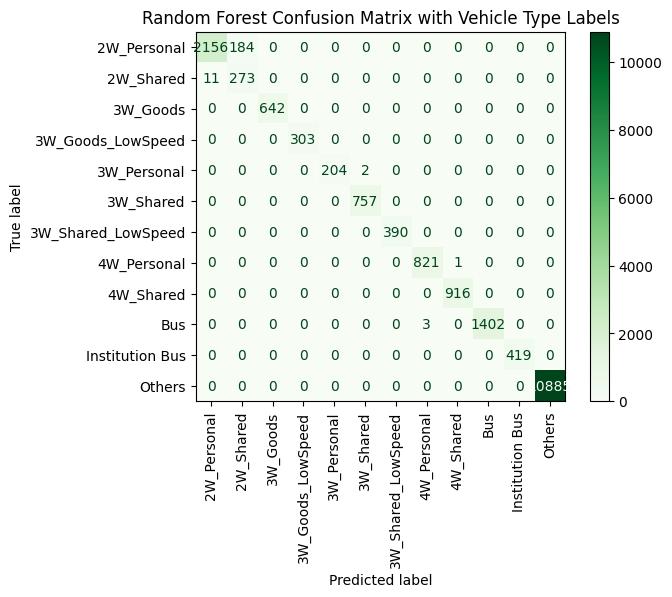

In [32]:
from sklearn.metrics import ConfusionMatrixDisplay

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Get actual class names
labels = le_target.classes_

# Plot with labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=90)
plt.title("Random Forest Confusion Matrix with Vehicle Type Labels")
plt.show()


In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_res, y_train_res)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


print("KNN CV scores:")
evaluate_model_cv(knn, X_train_res, y_train_res)

KNN Accuracy: 0.9697970984562961
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2340
           1       0.94      0.98      0.96       284
           2       0.84      0.86      0.85       642
           3       0.82      0.85      0.83       303
           4       0.89      0.81      0.84       206
           5       0.83      0.84      0.84       757
           6       0.83      0.85      0.84       390
           7       0.89      0.92      0.91       822
           8       0.93      0.91      0.92       916
           9       0.99      1.00      1.00      1405
          10       1.00      1.00      1.00       419
          11       1.00      1.00      1.00     10885

    accuracy                           0.97     19369
   macro avg       0.91      0.92      0.91     19369
weighted avg       0.97      0.97      0.97     19369

KNN CV scores:
Mean Accuracy: 0.9969
Mean F1-Weighted: 0.9969


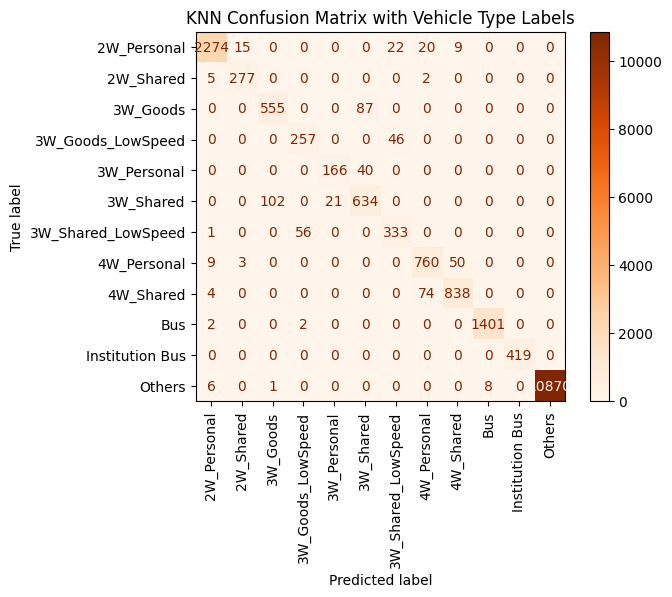

In [34]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
disp_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=le_target.classes_)
disp_knn.plot(cmap='Oranges', xticks_rotation=90)
plt.title("KNN Confusion Matrix with Vehicle Type Labels")
plt.show()


In [35]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, solver='lbfgs', class_weight='balanced')
lr.fit(X_train_res, y_train_res)
y_pred_lr = lr.predict(X_test)

print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


print("Logistic Regression CV scores:")
evaluate_model_cv(lr, X_train_res, y_train_res)

C:\Users\gsred\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.5376116474779287
              precision    recall  f1-score   support

           0       1.00      0.73      0.84      2340
           1       0.32      1.00      0.48       284
           2       0.82      1.00      0.90       642
           3       0.53      0.93      0.68       303
           4       0.08      0.92      0.15       206
           5       0.93      0.39      0.55       757
           6       0.83      0.50      0.62       390
           7       0.37      0.36      0.36       822
           8       0.60      0.86      0.70       916
           9       0.00      0.00      0.00      1405
          10       0.09      1.00      0.16       419
          11       0.96      0.49      0.65     10885

    accuracy                           0.54     19369
   macro avg       0.54      0.68      0.51     19369
weighted avg       0.80      0.54      0.60     19369

Logistic Regression CV scores:


C:\Users\gsred\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\gsred\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable

Mean Accuracy: 0.6475
Mean F1-Weighted: 0.6054


C:\Users\gsred\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


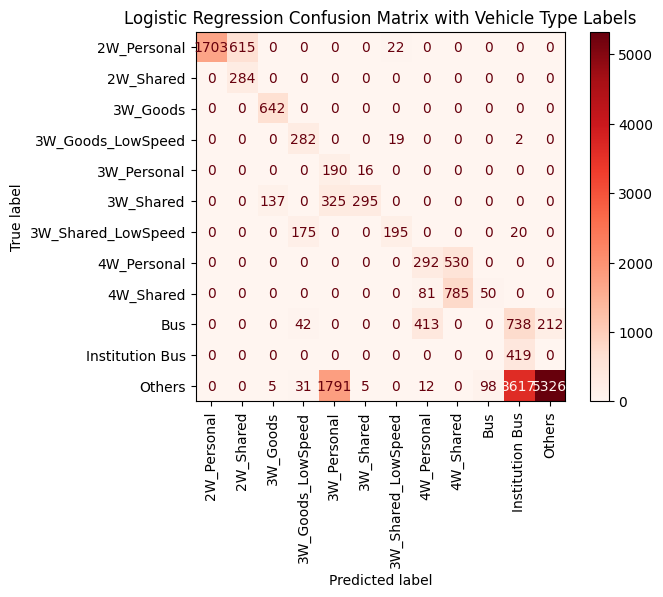

In [36]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=le_target.classes_)
disp_lr.plot(cmap='Reds', xticks_rotation=90)
plt.title("Logistic Regression Confusion Matrix with Vehicle Type Labels")
plt.show()


In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

# Store accuracies
results = pd.DataFrame({
    'Model': ['Random Forest', 'KNN', 'Logistic Regression'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_knn),
        accuracy_score(y_test, y_pred_lr)
    ]
})

# Sort by accuracy
results = results.sort_values(by='Accuracy', ascending=False)
print(results)




                 Model  Accuracy
0        Random Forest  0.989623
1                  KNN  0.969797
2  Logistic Regression  0.537612


C:\Users\gsred\AppData\Local\Temp\ipykernel_36700\2260255247.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis')


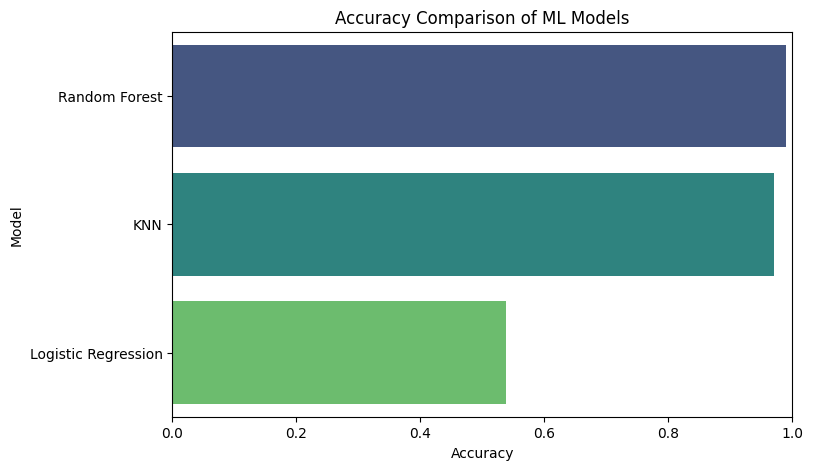

In [38]:
# Bar plot
plt.figure(figsize=(8,5)) 
sns.barplot(x='Accuracy', y='Model', data=results, palette='viridis') 
plt.xlim(0,1) 
plt.title("Accuracy Comparison of ML Models") 
plt.show()